In [27]:
import os
import pickle
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import csv
import commonFunctions as cf

In [72]:
stateCodes=pickle.load(open("stateCode.pickle","rb"))
paths=[str(i)+'/' for i in stateCodes]

yearMap=OrderedDict()
yearMapRev=OrderedDict()
count=0
for year in range(1980,2018):
    yearMap[str(year)]=count
    yearMapRev[count]=str(year)
    count+=1
    
# carbA=[6,41,53]
# carbB=[9,10,23,24,25,34,36,42,44,50,11]

# noState = ['"Guam"','"Puerto Rico"','"Hawaii"']
# nonCarb = [i for i in stateCodes if i not in carbA+carbB and stateCodes[i] not in noState]
carbA_=[6,41,53]
carbB_=[9,10,23,24,25,34,36,42,44,50,11]
noState = ['"Guam"','"Puerto Rico"','"Hawaii"','"Virgin Islands"','"Alaska"','"Country Of Mexico"']
nonCarb_ = [i for i in stateCodes if i not in carbA+carbB and stateCodes[i] not in noState]

carbA=[6,41,53]
carbB=[9,10,23,24,25,34,36,42,44,50,11]
nonCarb = [i for i in stateCodes if i not in carbA+carbB and stateCodes[i] not in noState]
nonCarb = [stateCodes[i].replace('"','') for i in nonCarb]
carbA = [stateCodes[i].replace('"','') for i in carbA]
carbB = [stateCodes[i].replace('"','') for i in carbB]

def setplot(plt,ax):
   

    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)

    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    return plt,ax

In [20]:
def sortByValue(tempx):
    by_key = sorted(tempx.items(), key=lambda d: d[0])
    x = sorted(by_key, key=lambda d: d[1], reverse=True)
    return x

def add_list(list_lt):
    return [sum(x) for x in zip(*list_lt)]

def process_list(list_lt):
    return [float(i) if i!='-' else 0 for i in list_lt]

In [67]:

data=OrderedDict()
for path in paths:
    key=path[:-1]
    for year in range(1980,2017):
        extendedPath=path+"Data/o3/"+str(year)
        counties=os.listdir(extendedPath)
        if key not in data:
            data[key]=OrderedDict()
        data[key][year]=len(counties)

In [73]:
regionData=OrderedDict()
for codes in data:
    for year in data[codes]:
        if year not in regionData:
            regionData[year]={'A':0,'B':0,'O':0,'USA':0}
        intCode = int(codes)
        if intCode in carbA_:
            regionData[year]['A']+=data[codes][year]
        elif intCode in carbB_:
            regionData[year]['B']+=data[codes][year]
        elif intCode in nonCarb_:
            regionData[year]['O']+=data[codes][year]
        regionData[year]['USA']+=data[codes][year]
ndata = OrderedDict()            
for statecode in data:
    ndata[stateCodes[int(statecode)].replace('"','')] = data[statecode]

In [51]:
energy_stateCodes = {}
f = open('energy/energy/yearly_statewise/energy_stateCodes.csv','r')
for l in f:
    row = l.strip().split(',')
    energy_stateCodes[row[0]] = row[1]

data_energy = OrderedDict()
msns = ['ESTCP','MGTCP','ENTCP','NGTCP','PATCP']
for msn_lt in msns:
    energypath = 'energy/energy/yearly_statewise/use_all_phy.csv'
    f = open(energypath,'r')
    header = next(f)
    reader = csv.reader(f,delimiter=',')
    msn_set = set()
    for row in reader:
        state,msn,years = row[1],row[2],row[23:]
        state = energy_stateCodes[state]
        if state in carbA+carbB+nonCarb+['United States','District of Columbia']:
            if state == 'United States':
                state = 'USA'
            if msn == msn_lt:
                msn_set.add(msn)
                if msn_lt not in data_energy:
                    data_energy[msn_lt] = OrderedDict()
                if state not in data_energy[msn_lt]:
                    data_energy[msn_lt][state] = []
                for i_lt in range(len(years)):
                    try:
                        years[i_lt] = float(years[i_lt])
                    except:
                        years[i_lt] = '-'
                data_energy[msn_lt][state].extend(years)
    f.close()

In [52]:
energypath = 'energy/energy/yearly_statewise/msn.csv'
energy_stateCodes = open('energy/energy/yearly_statewise/energy_stateCodes.csv','r').readlines()
msn_data = {}
f = open(energypath,'r')
reader2 = csv.reader(f)
for row in reader2:
    msn_data[row[0]] = row[1]

In [63]:
ndata_energy = OrderedDict()
for msn in msns:  
    ndata_energy[msn] = OrderedDict()
    ndata_energy[msn]['A'] = add_list([process_list(data_energy[msn][state]) for state in carbA])
    carbB_ = [i if i!='District Of Columbia' else 'District of Columbia' for i in carbB]
    ndata_energy[msn]['B'] = add_list([process_list(data_energy[msn][state]) for state in carbB_])
    ndata_energy[msn]['O'] = add_list([process_list(data_energy[msn][state]) for state in nonCarb])
    ndata_energy[msn]['USA'] = data_energy[msn]['USA']

In [53]:
corr_data = OrderedDict()
for msn in data_energy:
    index = list(data_energy).index(msn)
    for state in data_energy[msn]:
        if state != 'USA':
            if state not in corr_data:
                corr_data[state] = [np.nan]*len(data_energy)
            
            state_data1 = data_energy[msn][state]
           
            state_temp = 'District Of Columbia' if state=='District of Columbia' else state
            state_data2 = ndata[state_temp]
            x = state_data1
            y = [state_data2[i] for i in state_data2]
            #print(state,len(x),len(y))
            try:
                corr = cf.correlation(x,y,gaps=True)
                #print(state,corr)
                if corr[1] >= 32:
                    corr_data[state][index] = corr[0]
            except Exception as e:
                print(e,"NA",x,y)

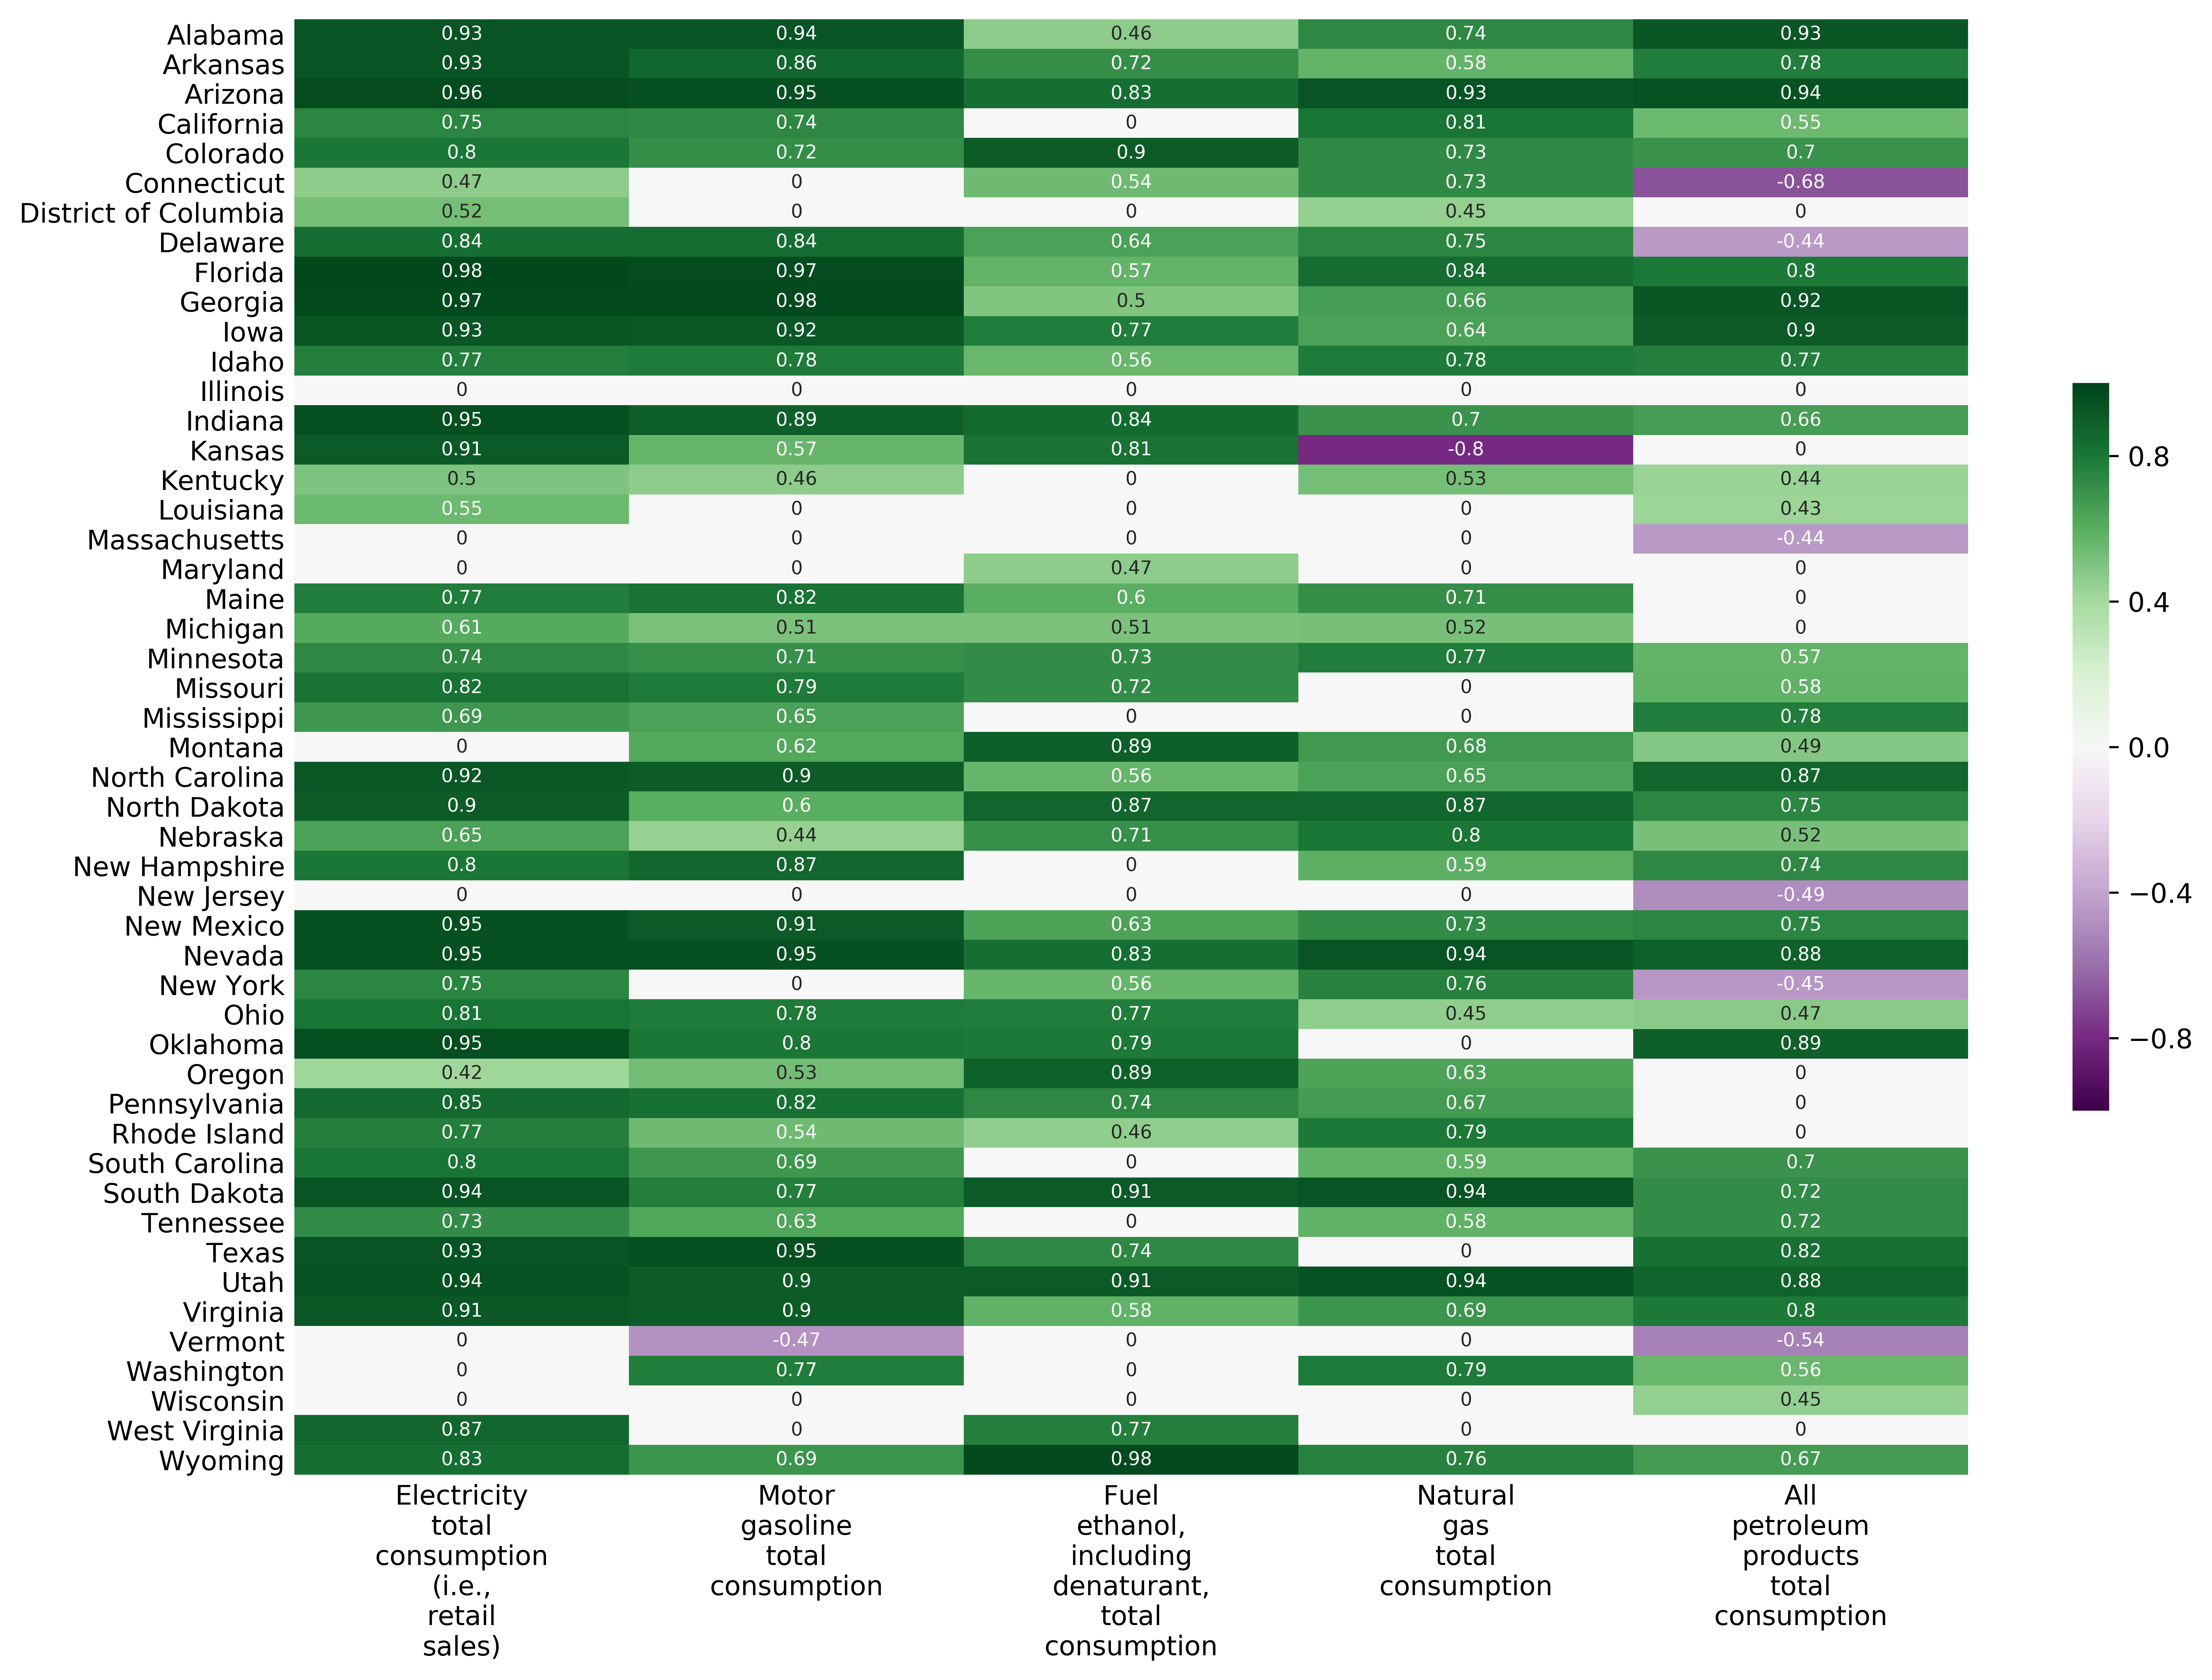

In [59]:
temp = []
for state in corr_data:
    temp.append(corr_data[state])
plt.close()
fig,ax = plt.subplots(figsize=(14,10),dpi=600)
plt,ax=setplot(plt,ax)
ax.tick_params(axis=u'both', which=u'both',length=0)
sns.heatmap(temp,vmax=1,vmin=-1,cmap=plt.get_cmap('PRGn'),cbar_kws={"shrink": .5},annot=True,annot_kws={"size":7})
plt.yticks(list(map(lambda x:x+0.5,range(len(temp)))),[i for i in corr_data],rotation=0)
plt.xticks(list(map(lambda x:x+0.5,range(len(msns)))),[msn_data[i].replace(' ','\n') for i in msns])
plt.savefig("Com/images/monitoring_sites_and_energy.png",dpi=600,bbox_inches='tight')
plt.show()

In [80]:
corr_data = OrderedDict()
for msn in ndata_energy:
    index = list(ndata_energy).index(msn)
    for state in ndata_energy[msn]:   
        if state not in corr_data:
            corr_data[state] = [np.nan]*len(ndata_energy)

        state_data1 = ndata_energy[msn][state]
        state_data2 = [regionData[i][state] for i in range(1980,2017)]
        x = state_data1
        y = state_data2
        print(state,len(x),len(y))
        try:
            corr = cf.correlation(x,y,gaps=True)
            #print(state,corr)
            if corr[1] >= 32:
                corr_data[state][index] = corr[0]
        except Exception as e:
            print(e,"NA",x,y)

A 37 37
B 37 37
O 37 37
USA 37 37
A 37 37
B 37 37
O 37 37
USA 37 37
A 37 37
B 37 37
O 37 37
USA 37 37
A 37 37
B 37 37
O 37 37
USA 37 37
A 37 37
B 37 37
O 37 37
USA 37 37


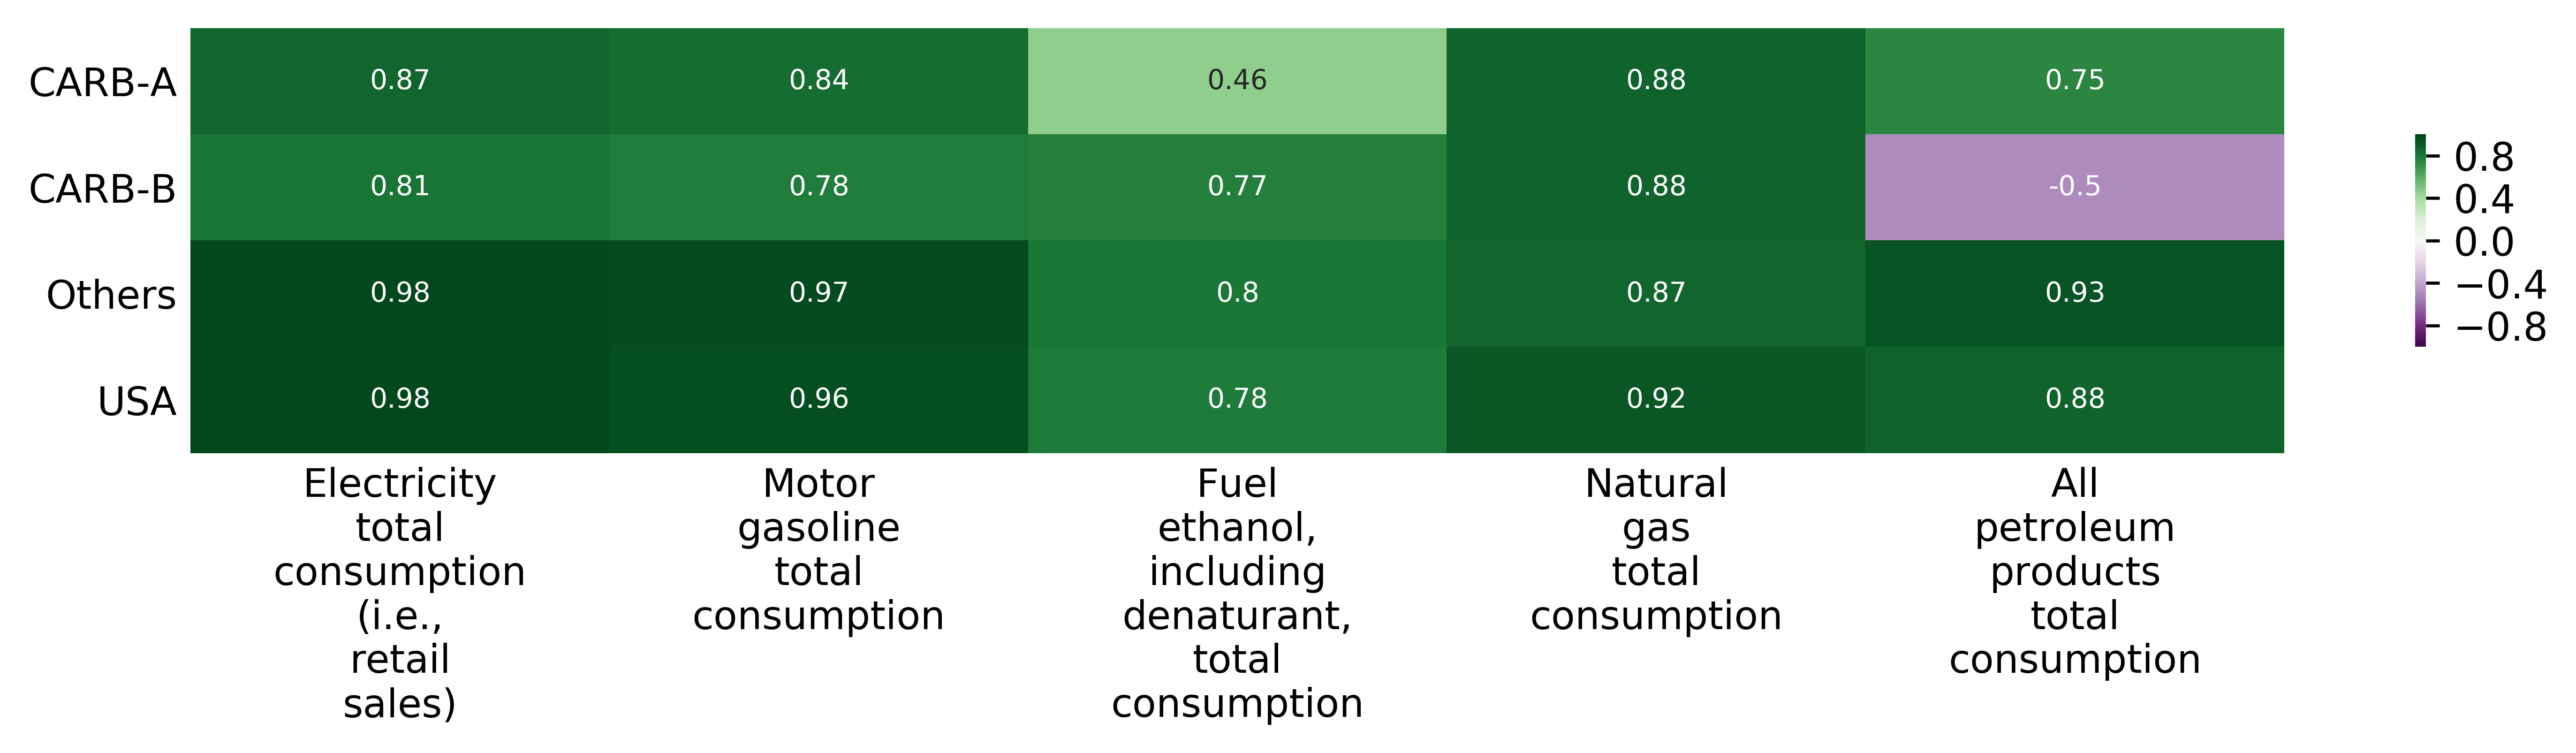

In [86]:
temp = []
for state in corr_data:
    temp.append(corr_data[state])
plt.close()
fig,ax = plt.subplots(figsize=(12,2),dpi=600)
plt,ax=setplot(plt,ax)
ax.tick_params(axis=u'both', which=u'both',length=0)
sns.heatmap(temp,vmax=1,vmin=-1,cmap=plt.get_cmap('PRGn'),cbar_kws={"shrink": .5},annot=True,annot_kws={"size":7})
plt.yticks(list(map(lambda x:x+0.5,range(len(temp)))),['CARB-A','CARB-B','Others','USA'],rotation=0)
plt.xticks(list(map(lambda x:x+0.5,range(len(msns)))),[msn_data[i].replace(' ','\n') for i in msns])
plt.savefig("Com/images/monitoring_sites_and_energy_usa.png",dpi=600,bbox_inches='tight')
plt.show()

In [78]:
ndata_energy['ESTCP'].keys()

odict_keys(['A', 'B', 'O', 'USA'])

In [ ]:
['']